In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteR1F09N/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpxp1ut23btfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE =len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [8]:
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

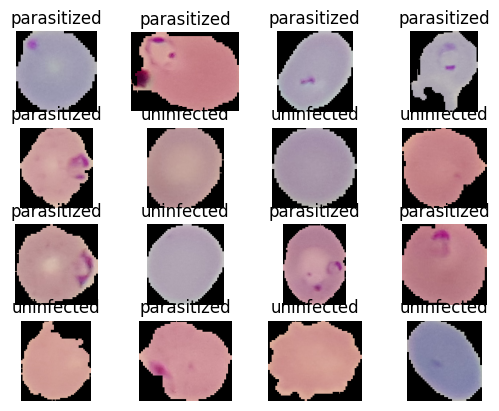

In [9]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [10]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [11]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [12]:
from ctypes import resize
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [13]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [14]:
BATCH_SIZE = 32

In [15]:
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
model = tf.keras.Sequential([

                             InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

                             Conv2D(filters = 6, kernel_size= 3, strides = 1 , padding = 'valid',activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2 , strides = 2),

                             Conv2D(filters = 16, kernel_size= 3, strides = 1 , padding = 'valid',activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2 , strides = 2),

                             Flatten(),
                             Dense(100,activation = 'relu'),
                             BatchNormalization(),
                             Dense(10,activation = 'relu'),
                             BatchNormalization(),
                             Dense(1,activation = 'sigmoid'),








])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

Functional API


In [21]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu') (func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu' )(x)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides = 2)(x)
x = Flatten() (x)
x = Dense (100, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense (10, activation = "relu")(x)
X = BatchNormalization () (x)

func_output = Dense (1, activation = "sigmoid")(x)

model1 = Model(func_input, func_output, name = "model1")
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)      64   

furthe dividing the fuctional model

In [24]:
func_input = Input (shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu') (func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides = 2)(x)

feature_extractor_model = Model (func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)

In [25]:
#feature extractor using sequential API

feature_extractor_seq_model = tf.keras.Sequential([
                              InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                              Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                              BatchNormalization(),
                              MaxPool2D (pool_size = 2, strides = 2),

                              Conv2D (filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                              BatchNormalization(),
                              MaxPool2D (pool_size = 2, strides = 2),
])
feature_extractor_seq_model. summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [33]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
x = feature_extractor_model(func_input)
#x = feature_extractor_seq_model(func_input) #we can use either

x = Flatten ()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense (10, activation = "relu") (x)
x = BatchNormalization()(x)

func_output = Dense (1, activation = "sigmoid")(x)

model_func = Model(func_input, func_output, name = "model_func")
model_func. summary()

Model: "model_func"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 46656)             0         
                                                                 
 dense_11 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_18 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 10)                1

Model Subclassing

In [38]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size ):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [41]:
class S_Model(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(S_Model, self).__init__()

    self.feature_extractor = FeatureExtractor (8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense (10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense (1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

sub_classed = S_Model(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)
sub_classed(tf.zeros([1, 224, 224, 3]))
sub_classed.summary()

Model: "s__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_14 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_24 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_15 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_25 (Ba  multiple                  40 

In [42]:
model.compile(optimizer = Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [43]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 52s 68ms/step - loss: 0.3311 - accuracy: 0.8655 - val_loss: 0.6120 - val_accuracy: 0.7681
Epoch 2/20
689/689 [==============================] - 51s 74ms/step - loss: 0.3661 - accuracy: 0.8165 - val_loss: 0.8096 - val_accuracy: 0.4962
Epoch 3/20
689/689 [==============================] - 42s 61ms/step - loss: 0.6613 - accuracy: 0.6007 - val_loss: 0.7187 - val_accuracy: 0.5296
Epoch 4/20
689/689 [==============================] - 51s 74ms/step - loss: 0.6673 - accuracy: 0.5948 - val_loss: 0.7193 - val_accuracy: 0.5604
Epoch 5/20
689/689 [==============================] - 42s 60ms/step - loss: 0.6456 - accuracy: 0.6246 - val_loss: 1.1077 - val_accuracy: 0.4922
Epoch 6/20
689/689 [==============================] - 42s 61ms/step - loss: 0.3509 - accuracy: 0.8521 - val_loss: 2.0459 - val_accuracy: 0.5699
Epoch 7/20
689/689 [==============================] - 41s 60ms/step - loss: 0.2202 - accuracy: 0.9238 - val_loss: 0.4142 - val_accuracy:

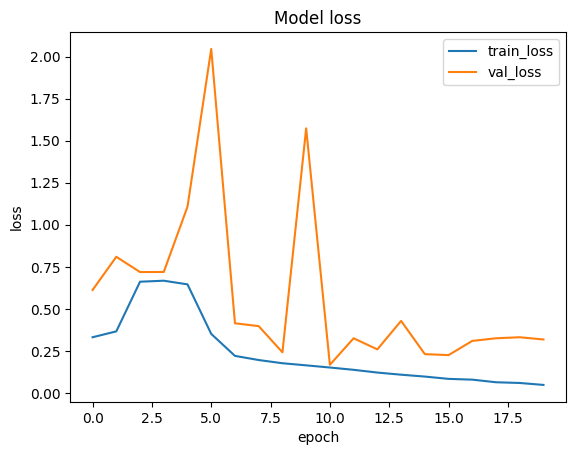

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

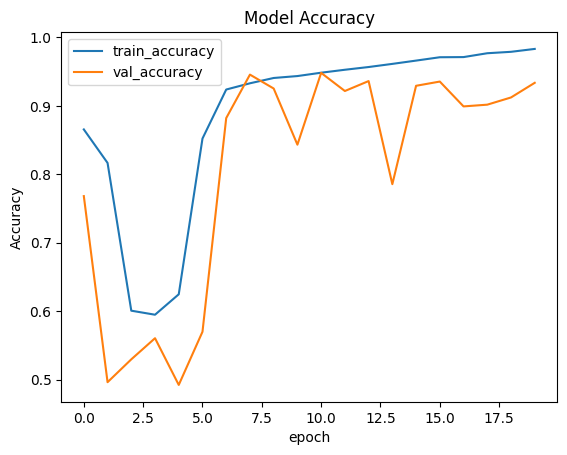

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [46]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [47]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 0.3292 - accuracy: 0.9304


[0.32920563220977783, 0.9303590655326843]

In [48]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 17ms/step


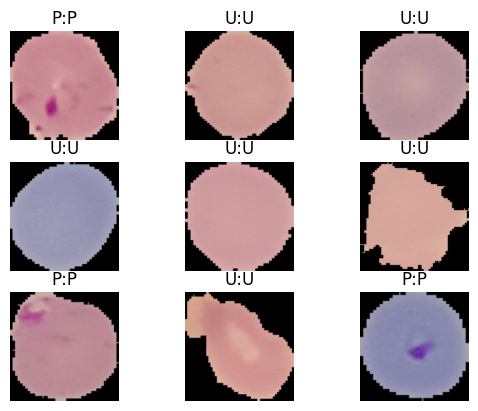

In [49]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+ 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')